In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import trompy as tp

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded as Type 3 fonts

In [3]:
DATAFOLDER = Path("..\\data")
FIGSFOLDER = Path("..\\figures")
FIGSFOLDER = Path("C:\\Users\\jmc010\\Dropbox\\Publications in Progress\\IPP Giulia paper\\figs")

save_figs = True

def tweak_df(df):

    return (df
            .query("session == 's4'")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

In [4]:
def get_licks_per_solution(row):
    filename = row.medfile
    # print(f"Processing {filename}")

    L, R = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "e"], remove_var_header=True)

    if "malt" in row.bottleL and "cas" in row.bottleR:
        med_var_malt, med_var_casein = L, R
    elif "malt" in row.bottleR and "cas" in row.bottleL:
        med_var_malt, med_var_casein = R, L
    else:
        raise ValueError("Bottles not found")
    
    return med_var_casein, med_var_malt

### Panel 2A

In [5]:
def get_cluster_number(licks, threshold=0.5):
    lickdata = tp.lickCalc(licks, burstThreshold=threshold)
    return lickdata["bNum"]

# get cluster number
PR_cas_cluster_num, PR_malt_cluster_num = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas_cluster_num.append(get_cluster_number(cas_licks))
    PR_malt_cluster_num.append(get_cluster_number(malt_licks))

NR_cas_cluster_num, NR_malt_cluster_num = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas_cluster_num.append(get_cluster_number(cas_licks))
    NR_malt_cluster_num.append(get_cluster_number(malt_licks))

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


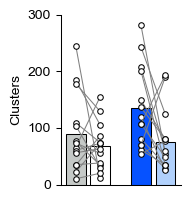

In [6]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

tp.barscatter([[NR_cas_cluster_num, NR_malt_cluster_num], [PR_cas_cluster_num, PR_malt_cluster_num],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=40
            );

ax.set_yticks([0, 100, 200, 300])
ax.set_ylabel("Clusters")

if save_figs:
    f.savefig(FIGSFOLDER / "2A_cluster number.pdf", dpi=300)

In [7]:
### Stats
data = {
    'subject': np.tile(np.arange(1, len(NR_cas_cluster_num) + len(PR_cas_cluster_num) + 1), 2),
    'diet': np.tile(["NR"] * len(NR_cas_cluster_num) + ["PR"] * len(PR_cas_cluster_num), 2),
    'solution': np.array(["cas"] * (len(NR_cas_cluster_num) + len(PR_cas_cluster_num)) + ["malt"] * (len(NR_malt_cluster_num) + len(PR_malt_cluster_num))),
    'licks': np.concatenate([NR_cas_cluster_num, PR_cas_cluster_num, NR_malt_cluster_num, PR_malt_cluster_num])
}

stats_df = pd.DataFrame(data)

aov = pg.mixed_anova(data=stats_df, dv='licks', subject='subject', within='solution', between='diet')

print(aov)

        Source            SS  DF1  DF2            MS         F     p-unc  \
0         diet  10017.875000    1   26  10017.875000  2.719527  0.111160   
1     solution  22842.160714    1   26  22842.160714  6.122269  0.020195   
2  Interaction   4884.446429    1   26   4884.446429  1.309154  0.262973   

        np2  eps  
0  0.094693  NaN  
1  0.190593  1.0  
2  0.047938  NaN  


In [8]:
## Posthocs

ncomps = 4 #because NR vs PR for each solution and cas vs malt for each diet group

# solution
_, p = ttest_rel(NR_cas_cluster_num, NR_malt_cluster_num)
print("NR cas vs NR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

_, p = ttest_rel(PR_cas_cluster_num, PR_malt_cluster_num)
print("PR cas vs PR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

# diet
_, p = ttest_ind(NR_cas_cluster_num, PR_cas_cluster_num)
print("NR cas vs PR cas = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

_, p = ttest_ind(NR_malt_cluster_num, PR_malt_cluster_num)
print("NR malt vs PR malt = {:.3f} ({:.3f} before correction))".format(tp.sidakcorr(p, ncomps=ncomps), p))

NR cas vs NR malt = 0.781 (0.316 before correction))
PR cas vs PR malt = 0.134 (0.035 before correction))
NR cas vs PR cas = 0.347 (0.101 before correction))
NR malt vs PR malt = 0.988 (0.668 before correction))


### Panel 2B

In [9]:
def get_cluster_size(licks, threshold=0.5):
    lickdata = tp.lickCalc(licks, burstThreshold=threshold)
    return lickdata["bMean"]

# get cluster size
PR_cas_cluster_size, PR_malt_cluster_size = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas_cluster_size.append(get_cluster_size(cas_licks))
    PR_malt_cluster_size.append(get_cluster_size(malt_licks))

NR_cas_cluster_size, NR_malt_cluster_size = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas_cluster_size.append(get_cluster_size(cas_licks))
    NR_malt_cluster_size.append(get_cluster_size(malt_licks))

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


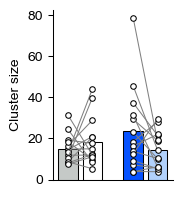

In [10]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

tp.barscatter([[NR_cas_cluster_size, NR_malt_cluster_size], [PR_cas_cluster_size, PR_malt_cluster_size],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=40
            );

ax.set_yticks([0, 20, 40, 60, 80])
ax.set_ylabel("Cluster size")

if save_figs:
    f.savefig(FIGSFOLDER / "2B_cluster size.pdf", dpi=300)

In [11]:
### Stats
data = {
    'subject': np.tile(np.arange(1, len(NR_cas_cluster_size) + len(PR_cas_cluster_size) + 1), 2),
    'diet': np.tile(["NR"] * len(NR_cas_cluster_size) + ["PR"] * len(PR_cas_cluster_size), 2),
    'solution': np.array(["cas"] * (len(NR_cas_cluster_size) + len(PR_cas_cluster_size)) + ["malt"] * (len(NR_malt_cluster_size) + len(PR_malt_cluster_size))),
    'licks': np.concatenate([NR_cas_cluster_size, PR_cas_cluster_size, NR_malt_cluster_size, PR_malt_cluster_size])
}

df_stats = pd.DataFrame(data)

aov = pg.mixed_anova(data=df_stats, dv='licks', subject='subject', within='solution', between='diet')

print(aov)

        Source          SS  DF1  DF2          MS         F     p-unc  \
0         diet   77.111697    1   26   77.111697  0.410589  0.527279   
1     solution  114.992040    1   26  114.992040  0.777337  0.386035   
2  Interaction  574.612166    1   26  574.612166  3.884334  0.059472   

        np2  eps  
0  0.015546  NaN  
1  0.029030  1.0  
2  0.129979  NaN  


### Panel 2C

In [12]:
# work out preference scores for later correlations
 
NR_pref, PR_pref = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    NR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))

for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    PR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))


In [13]:
def keep_specific_epoch(licks, tmin=0, tmax=3600):
    return [lick for lick in licks if tmin <= lick <= tmax]

def divide_bursts_into_first_and_third_epoch_byburstnumber(licks):
    
    lickdata = tp.lickCalc(licks, burstThreshold=0.5, minburstlength=3)
    bursts = lickdata["bLicks"]
    nbursts = len(bursts)
    epoch1 = np.mean(bursts[:nbursts//3])
    epoch3 = np.mean(bursts[nbursts//3*2:])
    
    # epoch1 = np.mean(bursts[1:4])
    # epoch3 = np.mean(bursts[-4:-1])

    return epoch1, epoch3

def divide_bursts_into_first_and_third_epoch_bytimeinsession(licks):
    
    e1_licks = keep_specific_epoch(licks, tmax=1200)
    e3_licks = keep_specific_epoch(licks, tmin=2400)
    
    epoch_output = []
    for epoch in [e1_licks, e3_licks]:
        
        try:
            lickdata = tp.lickCalc(epoch, burstThreshold=0.5, minburstlength=1)
            epoch_output.append(lickdata["bMean"])
        except:
            print(epoch)
            epoch_output.append(np.nan)
    
    return epoch_output[0], epoch_output[1]

dietgroup = "NR"
# get cluster number
cas_size_first, cas_size_last = [], []
malt_size_first, malt_size_last = [], []
for row in df.query("dietgroup == @dietgroup").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    # c1, c3 = divide_bursts_into_first_and_third_epoch_bytimeinsession(cas_licks)
    # cas_size_first.append(c1)
    # cas_size_last.append(c3)

    # m1, m3 = divide_bursts_into_first_and_third_epoch_bytimeinsession(malt_licks)
    # malt_size_first.append(m1)
    # malt_size_last.append(m3)
    
    c1, c3 = divide_bursts_into_first_and_third_epoch_byburstnumber(cas_licks)
    cas_size_first.append(c1)
    cas_size_last.append(c3)

    m1, m3 = divide_bursts_into_first_and_third_epoch_byburstnumber(malt_licks)
    malt_size_first.append(m1)
    malt_size_last.append(m3)

delta_cas = np.array(cas_size_last) / np.array(cas_size_first) * 100
delta_malt = np.array(malt_size_last) / np.array(malt_size_first) * 100


c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


In [14]:
cas1, cas3, malt1, malt3 = [], [], [], []
for c1, c3, m1, m3 in zip(cas_size_first, cas_size_last, malt_size_first, malt_size_last):
    if np.isnan(c1) or np.isnan(c3) or np.isnan(m1) or np.isnan(m3):
        continue
    else:
        cas1.append(c1)
        cas3.append(c3)
        malt1.append(m1)
        malt3.append(m3)
        
delta_cas = np.array(cas3) / np.array(cas1) * 100
delta_malt = np.array(malt3) / np.array(malt1) * 100


In [15]:
### Stats
# data_nr = {
#     'subject': np.tile(np.arange(1, len(cas1) + 1), 4),
#     'diet': np.array(["NR"] * (len(cas1) * 4)),
#     'solution': np.hstack([np.tile("cas",(len(cas1) * 2)), np.tile("malt",(len(cas1) * 2))]),
#     'epoch': np.hstack([np.tile("first",(len(cas1))), np.tile("third",(len(cas1))), np.tile("first",(len(cas1))), np.tile("third",(len(cas1)))]),
#     'licks': np.concatenate([cas1, cas3, malt1, malt3])
# }

# df_stats = pd.DataFrame(data)

# aov = pg.mixed_anova(data=df_stats, dv='licks', subject='subject', within=['solution', 'epoch'])

#print(aov)

## Unable to run 3-way ANOVA with pingouin so will run using JASP

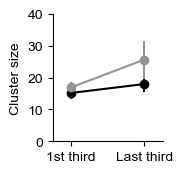

In [16]:
cas1, cas3 = cas_size_first, cas_size_last
malt1, malt3 = malt_size_first, malt_size_last

def sem(data):
    return np.std(data) / np.sqrt(len(data))

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.2, "top": 0.95, "right": 0.90})

ax.errorbar([1, 2], [np.mean(cas1), np.mean(cas3)],
            yerr=[sem(cas1), sem(cas3)],
            fmt="o-", color="black", label="Cas")

ax.errorbar([1, 2], [np.mean(malt1), np.mean(malt3)],
            yerr=[sem(malt1), sem(malt3)],
            fmt="o-", color="xkcd:grey", label="Malt")

ax.set_ylim(0,40)
ax.set_xlim(0.75, 2.25)
ax.set_ylabel("Cluster size")
ax.set_xticks([1, 2], labels=["1st third", "Last third"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "2C-left_cluster size first and last epoch_NR.pdf", dpi=300)

### Panel 2D - left

Cas: r = -0.039, p = 0.895
Malt: r = -0.472, p = 0.089


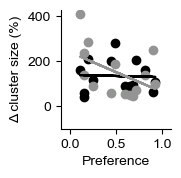

In [17]:
from scipy.stats import linregress

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.95, "right": 0.90})

ax.scatter(NR_pref, delta_cas, color="black", label="Cas")
ax.scatter(NR_pref, delta_malt, color="xkcd:grey", label="Malt")

slope, intercept, r_value, p_value, std_err = linregress(NR_pref, delta_cas)
cas_regression = slope * np.array(NR_pref) + intercept
print("Cas: r = {:.3f}, p = {:.3f}".format(r_value, p_value))

ax.plot(NR_pref, cas_regression, color="black")

slope, intercept, r_value, p_value, std_err = linregress(NR_pref, delta_malt)
malt_regression = slope * np.array(NR_pref) + intercept
print("Malt: r = {:.3f}, p = {:.3f}".format(r_value, p_value))

ax.plot(NR_pref, malt_regression, color="xkcd:grey")

ax.set_ylim(-100, 430)
ax.set_xlim(-0.1, 1.1)
ax.set_xticks([0, 0.5, 1])

ax.set_ylabel("\u0394 cluster size (%)")
ax.set_xlabel("Preference")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "2D-left_cluster size vs preference_NR.pdf", dpi=300)

In [18]:
dietgroup = "PR"
# get cluster number
cas_size_first, cas_size_last = [], []
malt_size_first, malt_size_last = [], []
for row in df.query("dietgroup == @dietgroup").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    c1, c2 = divide_bursts_into_first_and_third_epoch_byburstnumber(cas_licks)
    cas_size_first.append(c1)
    cas_size_last.append(c2)

    m1, m2 = divide_bursts_into_first_and_third_epoch_byburstnumber(malt_licks)
    malt_size_first.append(m1)
    malt_size_last.append(m2)

delta_cas = np.array(cas_size_last) / np.array(cas_size_first) * 100
delta_malt = np.array(malt_size_last) / np.array(malt_size_first) * 100

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


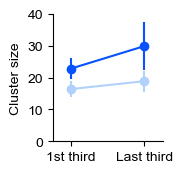

In [19]:
f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.2, "top": 0.95, "right": 0.90})

ax.errorbar([1, 2], [np.mean(cas_size_first), np.mean(cas_size_last)],
            yerr=[sem(cas_size_first), sem(cas_size_last)],
            fmt="o-", color="xkcd:electric blue", label="Cas")

ax.errorbar([1, 2], [np.mean(malt_size_first), np.mean(malt_size_last)],
            yerr=[sem(malt_size_first), sem(malt_size_last)],
            fmt="o-", color="xkcd:powder blue", label="Malt")

ax.set_ylim(0,40)
ax.set_xlim(0.75, 2.25)
ax.set_ylabel("Cluster size")
ax.set_xticks([1, 2], labels=["1st third", "Last third"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "2C-right_cluster size first and last epoch_PR.pdf", dpi=300)

Cas: r = 0.537, p = 0.048
Malt: r = 0.280, p = 0.332


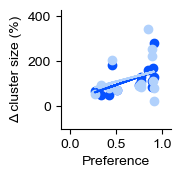

In [20]:
from scipy.stats import linregress

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.95, "right": 0.90})

ax.scatter(PR_pref, delta_cas, color="xkcd:electric blue", label="Cas")
ax.scatter(PR_pref, delta_malt, color="xkcd:powder blue", label="Malt")

slope, intercept, r_value, p_value, std_err = linregress(PR_pref, delta_cas)
cas_regression = slope * np.array(PR_pref) + intercept
print("Cas: r = {:.3f}, p = {:.3f}".format(r_value, p_value))

ax.plot(PR_pref, cas_regression, color="xkcd:electric blue")

slope, intercept, r_value, p_value, std_err = linregress(PR_pref, delta_malt)
malt_regression = slope * np.array(PR_pref) + intercept
print("Malt: r = {:.3f}, p = {:.3f}".format(r_value, p_value))

ax.plot(PR_pref, malt_regression, color="xkcd:powder blue")

ax.set_ylim(-100, 430)
ax.set_xlim(-0.1, 1.1)
ax.set_xticks([0, 0.5, 1])

ax.set_ylabel("\u0394 cluster size (%)")
ax.set_xlabel("Preference")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

if save_figs:
    f.savefig(FIGSFOLDER / "2D-right_cluster size first and last epoch_PR.pdf", dpi=300)